In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
# Load data
df = pd.read_csv('tweet.csv', index_col=[0], encoding='utf-8')
df

,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...
...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan ...
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,netral,Mari bangun bangsa dgn mendukung perekonomian ...
1813,netral,Bantu majukan perekonomian bangsa bersama Pak ...


In [6]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 42.5+ KB


In [8]:
# Check for missing values
df.isna().sum()

sentimen    0
tweet       0
dtype: int64

In [10]:
# Define text cleaning function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s#@:,/\.\-]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic\.twitter\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\?', ' ', text)
    text = re.sub(r'!', ' ', text)
    text = re.sub(r',', ' ', text)
    text = re.sub(r':', ' ', text)
    text = re.sub(r'\-', ' ', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\.+', ' ', text)
    text = re.sub(r'\.', '', text)
    text = re.sub(r'^\s+|\s+$', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

In [12]:
# Define function to extract hashtags
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

In [14]:
# Define function to extract mentions
def extract_mentions(text):
    return re.findall(r'@\w+', text)

In [18]:
# Import additional libraries for NLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nlp_id.stopword import StopWord
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nlp_id.lemmatizer import Lemmatizer

In [20]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rohad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rohad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Define stopword removal functions
def stopword_nltk(text):
    id_stopwords = stopwords.words('indonesian')
    tokens = word_tokenize(text)
    filtered_words = [word for word in tokens if word.lower() not in id_stopwords]
    result = ' '.join(filtered_words)
    return result

In [26]:
def stopword_nlp_id(text):
    stop_word = StopWord()
    result = stop_word.remove_stopword(text)
    return result

In [28]:
def stopword_sastrawi(text):
    factory = StopWordRemoverFactory()
    stopwords = factory.create_stop_word_remover()
    result = stopwords.remove(text)
    return result

In [30]:
# Define stemming and lemmatization functions
def stemming_sastrawi(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    result = stemmer.stem(text)
    return result

In [32]:
def stem_lemmatizer_nlp_id(text):
    lemmatizer = Lemmatizer()
    result = lemmatizer.lemmatize(text)
    return result

In [34]:
# Apply text preprocessing
df['text_cleansed'] = df['tweet'].apply(clean_text)
df['stopworded'] = df['text_cleansed'].apply(stopword_nlp_id)
df['hashtags'] = df['tweet'].apply(extract_hashtags)
df['mentions'] = df['tweet'].apply(extract_mentions)
df['tweet_length'] = df['tweet'].apply(len)

In [36]:
df = df.drop(['tweet'], axis=1)
df = df.drop(['text_cleansed'], axis=1)

In [38]:
df = df.rename(columns={"stopworded": 'tweet',
                        "hashtags": 'hashtags',
                        "mentions": 'mentions'})

In [40]:
df

,sentimen,tweet,hashtags,mentions,tweet_length
0,negatif,indonesia dihargai bangsa asing berita hoax bu...,[],"[@prabowo, @rockygerung]",195
1,netral,batuan langka tasbih jokowi hadiah habib luthf...,[],[],93
2,netral,era jokowi ekonomi indonesia,"[#01IndonesiaMaju, #JokowiLagi, #JokowiMenangT...",[],126
3,positif,sumatera selatan asian games berdampak pd ekon...,[],[],128
4,negatif,negara ngutang bngun infrastruktur dipake masy...,[],[],244
...,...,...,...,...,...
1810,netral,negarawan sejati sll bangga mengedepankan harg...,[#2019GantiPresiden],[],99
1811,netral,1 hrs ceramah damai indonesiaku 2 perekonomian...,[#PutihkanGBK],[],80
1812,netral,mari bangun bangsa dgn mendukung perekonomian ...,[],[],148
1813,netral,bantu majukan perekonomian bangsa jokowi yuk,[],[],121


<b>Exploratory Data Analysis (EDA)

In [44]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1815 entries, 0 to 1814
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sentimen      1815 non-null   object
 1   tweet         1815 non-null   object
 2   hashtags      1815 non-null   object
 3   mentions      1815 non-null   object
 4   tweet_length  1815 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 85.1+ KB


In [46]:
# Count Sentiment Distribution
len_negative = len(df[df['sentimen'] == 'negatif']['sentimen'])
len_neutral = len(df[df['sentimen'] == 'netral']['sentimen'])
len_positive = len(df[df['sentimen'] == 'positif']['sentimen'])

In [48]:
print("Sentiment Distribution:")
print("Negatif:", len_negative)
print("Netral:", len_neutral)
print("Positive:", len_positive)

Sentiment Distribution:
Negatif: 596
Netral: 607
Positive: 612


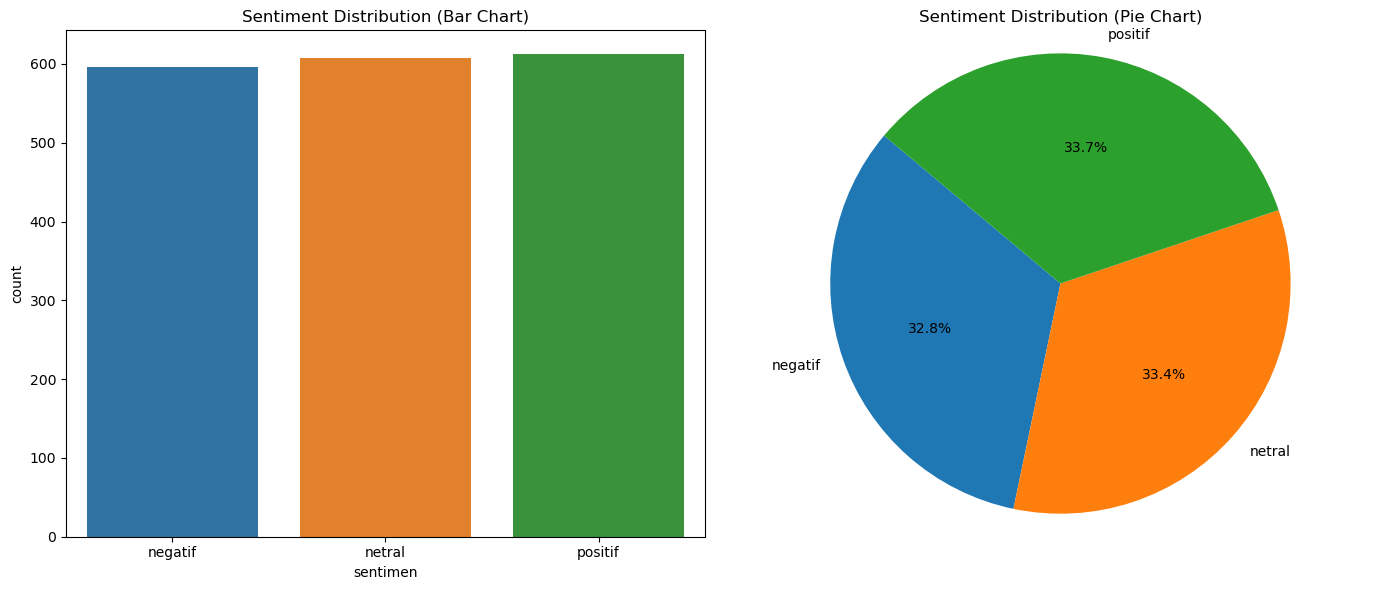

In [52]:
# Visualize Sentiment Distribution (Bar Chart & Pie Chart)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(x='sentimen', data=df, ax=ax1)
ax1.set_title('Sentiment Distribution (Bar Chart)')

sentiment_counts = df['sentimen'].value_counts().iloc[::-1]
ax2.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
ax2.set_title('Sentiment Distribution (Pie Chart)')
ax2.axis('equal')

plt.tight_layout()
plt.show()

In [61]:
# Count the most frequent Hashtags
hashtags = df.explode('hashtags')
top_hashtags = hashtags['hashtags'].value_counts().head(10)
top_hashtags

hashtags
#PrabowoSalahkanSBY          90
#PilihOrangBaik              61
#PilihBajuPutih              60
#JokowiMenangTotalDebat      55
#PilihJelasIslamnya          55
#UASdifitnahKejiDanBrutal    34
#DebatPilpres2019            22
#TusukPrabowoSandi           21
#2019GantiPresiden           20
#YourTurnBro                 18
Name: count, dtype: int64

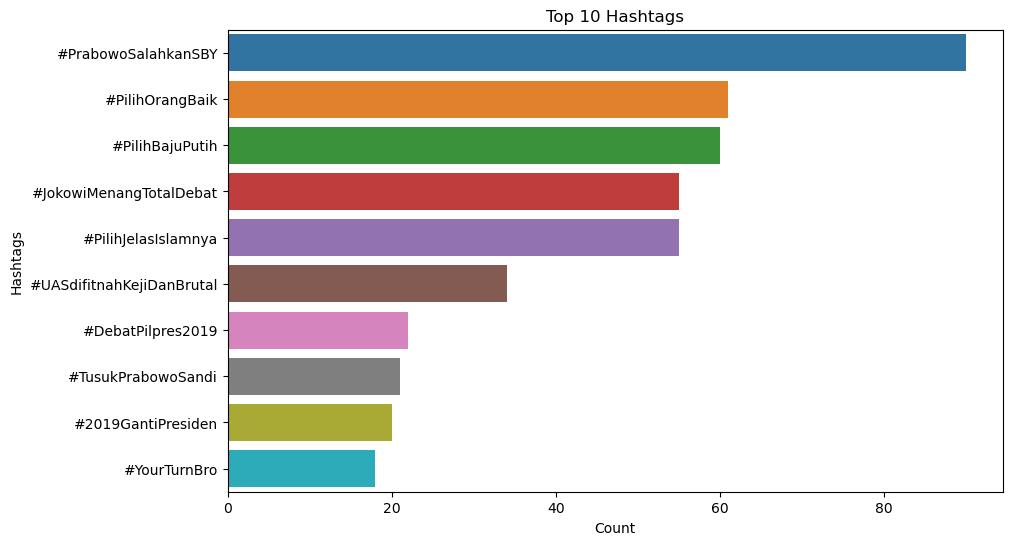

In [63]:
# Visualize the most frequent Hashtags
plt.figure(figsize=(10, 6))
sns.barplot(x=top_hashtags.values, y=top_hashtags.index)
plt.title('Top 10 Hashtags')
plt.xlabel('Count')
plt.ylabel('Hashtags')
plt.show()

In [65]:
# Count the most frequent mentioned users
mentions = df.explode('mentions')
top_mentions = mentions['mentions'].value_counts().head(10)
top_mentions

mentions
@jokowi          233
@prabowo         148
@sandiuno        108
@Jokowi           18
@KHMarufAmin_     13
@SBYudhoyono      10
@saaebunglon       8
@sukangetweet      8
@bocahsosmed       8
@kumparannews      7
Name: count, dtype: int64

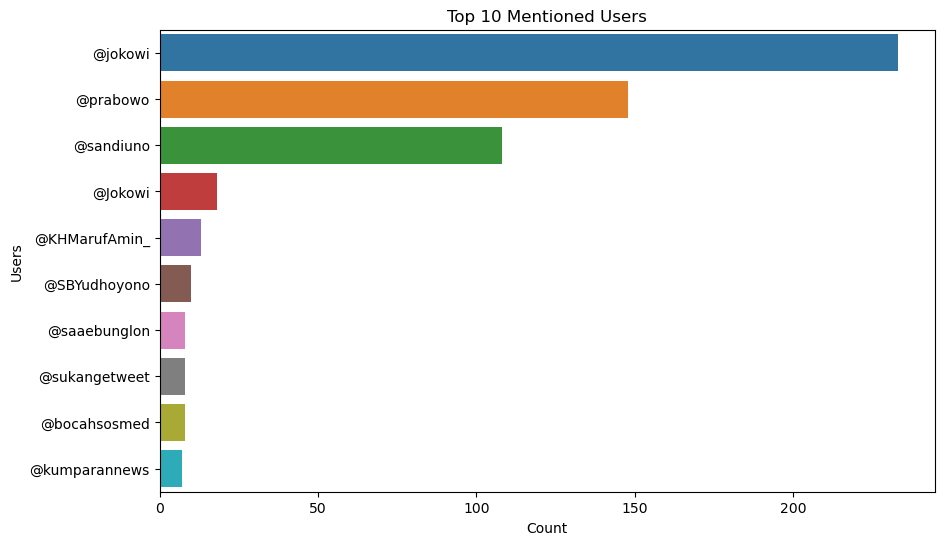

In [67]:
# Visualize the most frequent mentioned users
plt.figure(figsize=(10, 6))
sns.barplot(x=top_mentions.values, y=top_mentions.index)
plt.title('Top 10 Mentioned Users')
plt.xlabel('Count')
plt.ylabel('Users')
plt.show()

C:\Users\rohad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


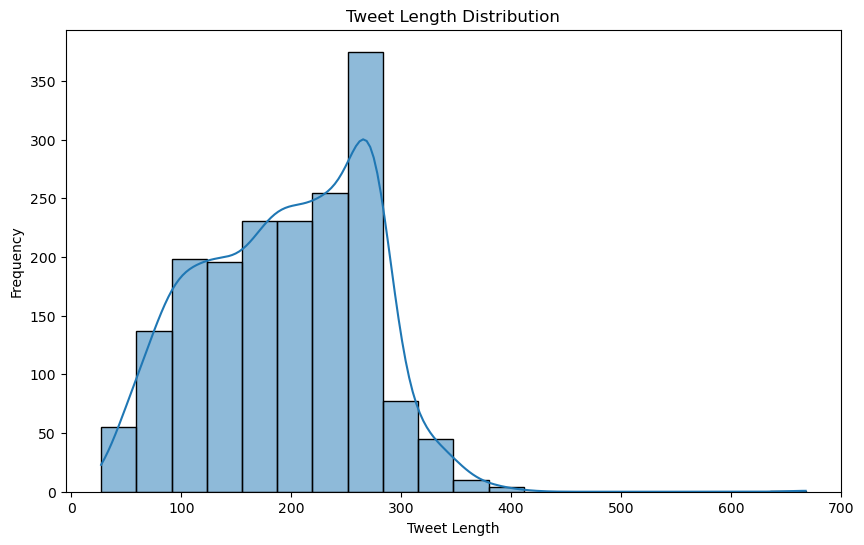

In [69]:
# Visualize tweet length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], bins=20, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

In [71]:
# Define the Stop Words for WordCloud
stop_word = StopWord()
id_stopwords = stop_word.get_stopword()
len(id_stopwords)

1168

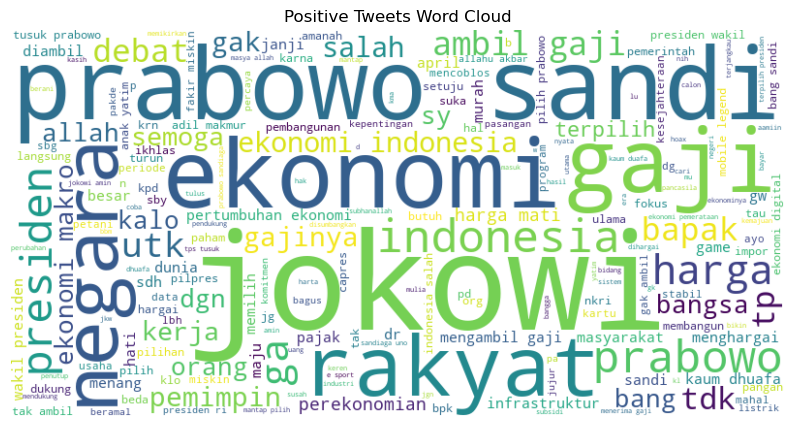

In [77]:
# Visualize Positive Sentiments to WordCloud
positive_words = ' '.join(df[df['sentimen'] == 'positif']['tweet'])
wordcloud = WordCloud(stopwords=id_stopwords, background_color='white', width=800, height=400).generate(positive_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Tweets Word Cloud')
plt.axis('off')
plt.show()

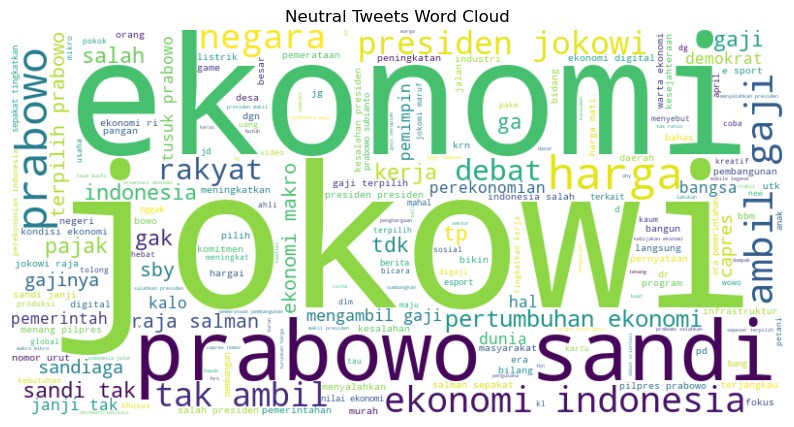

In [79]:
# Visualize Neutral Sentiments to WordCloud
neutral_words = ' '.join(df[df['sentimen'] == 'netral']['tweet'])
wordcloud = WordCloud(stopwords=id_stopwords, background_color='white', width=800, height=400).generate(neutral_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Neutral Tweets Word Cloud')
plt.axis('off')
plt.show()

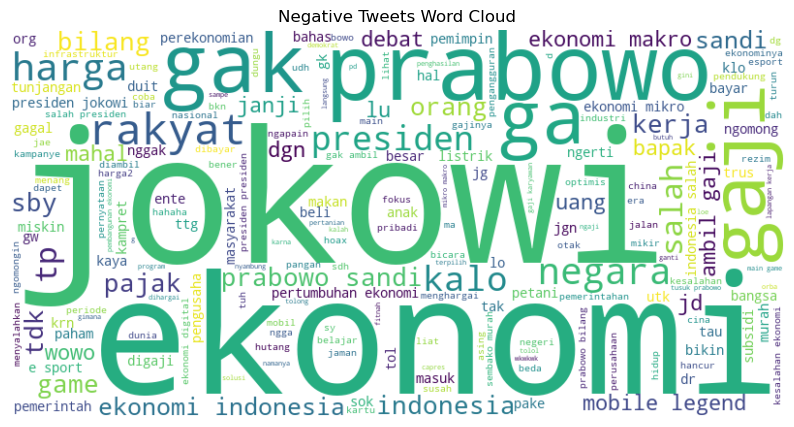

In [81]:
# Visualize Negative Sentiments to WordCloud
negative_words = ' '.join(df[df['sentimen'] == 'negatif']['tweet'])
wordcloud = WordCloud(stopwords=id_stopwords, background_color='white', width=800, height=400).generate(negative_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Tweets Word Cloud')
plt.axis('off')
plt.show()

In [83]:
# Label Encoding
sentiment_mapping = {'negatif': 0, 'netral': 1, 'positif': 2}
df['sentimen_labels'] = df['sentimen'].map(sentiment_mapping)
df

,sentimen,tweet,hashtags,mentions,tweet_length,sentimen_labels
0,negatif,indonesia dihargai bangsa asing berita hoax bu...,[],"[@prabowo, @rockygerung]",195,0
1,netral,batuan langka tasbih jokowi hadiah habib luthf...,[],[],93,1
2,netral,era jokowi ekonomi indonesia,"[#01IndonesiaMaju, #JokowiLagi, #JokowiMenangT...",[],126,1
3,positif,sumatera selatan asian games berdampak pd ekon...,[],[],128,2
4,negatif,negara ngutang bngun infrastruktur dipake masy...,[],[],244,0
...,...,...,...,...,...,...
1810,netral,negarawan sejati sll bangga mengedepankan harg...,[#2019GantiPresiden],[],99,1
1811,netral,1 hrs ceramah damai indonesiaku 2 perekonomian...,[#PutihkanGBK],[],80,1
1812,netral,mari bangun bangsa dgn mendukung perekonomian ...,[],[],148,1
1813,netral,bantu majukan perekonomian bangsa jokowi yuk,[],[],121,1


In [85]:
# Feature Extraction / Text Vectorizer
# Using TF-IDF feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df['tweet'].values.astype('U'))

In [87]:
# Check TF-IDF array shape
tfidf.toarray().shape

(1815, 6462)

In [89]:
# Splitting Data
# Define X and Y
X = tfidf.toarray()
y = np.array(df['sentimen_labels'])

In [97]:
# Split Data by 80% and 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [98]:
X_train.shape

(1452, 6462)

In [102]:
X_test.shape

(363, 6462)

<b>Modeling

In [106]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier()

In [108]:
model_gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [109]:
train_accuracy = accuracy_score(y_train, y_pred_train)
train_accuracy

0.8202479338842975

<b>Model Evaluation

In [114]:
# Gradient Boosting
y_pred = model_gb.predict(X_test)

print("Gradient Boosting Evaluation:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score (per-class):", precision_score(y_test, y_pred, average=None))
print("Recall Score (per-class):", recall_score(y_test, y_pred, average=None))
print("F1 Score (per-class):", f1_score(y_test, y_pred, average=None))

Gradient Boosting Evaluation:
Accuracy Score: 0.5647382920110193
Precision Score (per-class): [0.53731343 0.56034483 0.60176991]
Recall Score (per-class): [0.62608696 0.55084746 0.52307692]
F1 Score (per-class): [0.57831325 0.55555556 0.55967078]
